# Prosessering av Energy Dispersive X-ray Spectroscopy data

Denne Jupyter Notebooken viser hvordan Energy Dispersive X-ray Spectroscopy (EDS) data kan analyseres. Spektroskopi er en veldig viktig datatype "klasse", som dukker opp i mange forskjellige teknikker.

### Målet med denne notebooken

- Dere skal kunne prosessere EDS dataene dere tok opp i SEM-laben
- Bli komfortable med å jobbe med spektroskopidata
- Lage figur som viser kjemisk komposisjon i dataene deres

### Notebook-planen

- Åpne datasettet, og utforske det
- Finne ut hvilke grunnstoffer som er i prøvematerialet
- Lage figur av dette

## Importere biblioteker

Først, plotte-biblioteket. Dette kan enten være `%matplotlib qt` for egne vinduer for plottene, eller `%matplotlib widget` for å få plottene i selve Jupyter Notebooken.

In [16]:
%matplotlib qt

Så importere HyperSpy

In [17]:
import hyperspy.api as hs

## Åpne dataset

Dette gjøres via `hs.load`, som kan åpne en rekke dataformater, spesielt innenfor elektronmikroskopi. Velg et av EDS datasettene deres, disse skal ha:

- `.hspy` filformat
- Ha filnavn som inneholder noe med: `EDS` eller `EDX`

Lage et objekt som heter `s`

In [18]:
s = hs.load('Map Data 2.hdf5')

In [4]:
#s2 = hs.load('Map Data 10.hdf5')
#s2.plot()

Så skriv `s` i cellen under, og kjør den

In [19]:
s

<EDSSEMSpectrum, title: , dimensions: (1024, 704|1024)>

In [20]:
s.metadata

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       ├── live_time = 180.223999023
│       │       └── real_time = 299.426818848
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       └── beam_energy = 10.0
├── General
│   ├── date = 10/6/2021 5:05:45 PM
│   ├── original_filename = Map Data 2.rpl
│   ├── time = 
│   └── title = 
└── Signal
    ├── binned = True
    ├── signal_type = EDS_SEM
    └── stageTilt = 0.0

Her ser vi et par viktige ting: signalet er et `EDSSEMSpectrum`, og den har 3 dimensjoner! 
    
Dimensjonene ser vi helt i slutten, som har 3 tall (som nok vil være annerledes for deres datasett): `(512, 352|1024)`. Tallene til venstre for `|` er navigasjonsdimensjonene, mens tallet til høyre for `|` er signaldimensjonen: `(NAVIGASJON 0, NAVIGASJON 1|SIGNAL 1)`.

I denne datatypen, så er de 2 navigasjonsdimensjonene probe-posisjonen, og signaldimensjonen er energien til røntgenstrålene.

Dette betyr at signaldimensjonen er 1-dimensjonal, som stemmer bra med at dette er spektroskopisk data.

(Hvis signalet IKKE er `EDSSEMSpectrum`, så kjør `s.set_signal_type("EDS_SEM")`.

## Enkel utforskning av dataene

Nå kan vi visualisere dataene, og se hvordan spektrumene ser ut. Bruk `plot` funksjonen i `s`, og utforsk datasettet.

<img src="figurer/sem_eds_navigator.jpg" width=900 height=900 />

In [21]:
s.plot()

Her ser vi at hver probe-posisjon har veldig få røntgen-tellinger, ergo at signalet ikke er særlig bra. Noen steder kan vi se at det er klare topper, men disse er for det meste under 10 tellinger.

Dette skal vi gjøre noe med, men først vil vi utforske datasettet som funksjon av røntgenstråle-energien. Bruk transpose funksjonaliteten i s, og lag et nytt signal `st`: `st = s.T`

In [22]:
st = s.T

Skriv `st` i cellen under, og kjør den.

In [23]:
st

<Signal2D, title: , dimensions: (1024|1024, 704)>

Nå er signalet `Signal2D`: navigasjon- og signal-dimensjonene har blitt byttet om. Så nå kan vi navigere over datasettet som en funksjon av røntgen-energien, istedet for probe-posisjonen.

Så plot `st`. Merk at nå er navigatoren i "røntgen" plottet.

<img src="figurer/eds_transpose.jpg" width=900 height=900 />

Flytt navigatoren frem og tilbake, spesielt på de klare toppene, og se om forskjelliges steder på prøven lyser opp.

In [24]:
st.plot()

Nå er røntgen-tellingene mye høyere, siden det er en sum av alle probe-posisjonene.

Så vi ser at det er noe interessant i dataene. Det neste steget er å lage bilder som viser hvor de forskjellige grunnstoffene er.

## Mer avansert

### Finne grunnstoffene

Det første vi må gjøre her, er å finne ut hvilke grunnstoffer vi har i prøvematerialet.

Enkleste måten å gjøre dette på, er å se på toppene vi har røntgen-signalet, kombinert med det vi vet om prøvematerialet.

Så: summer opp alle probeposisjonene, til et røntgen-energi signal. Bruk `sum` funksjonen i `s` til å lage et nytt signal `s_sum`.

In [25]:
s_sum = s.sum()

Så bruk `plot` funksjonen i `s_sum` til å visualisere dette signal, og finn ut hva slags grunnstoffer vi har.

<img src="figurer/eds_sum.jpg" width=900 height=900 />

Dere kan se hvilke topper de forskjellige grunnstoffene lager, ved for eksempel å bruke denne: https://www.jeolusa.com/DesktopModules/LiveContent/API/Image/Get?mid=4725&eid=1&Type=View&PortalId=2

In [26]:
s_sum.plot()

**Gå igjennom alle toppene, og prøv å finn ut hvilket grunnstoff de tilhører.**

Merk at samme grunnstoff kan ha flere topper, så hvis dere er usikre så er et triks å sjekke om de andre toppene også er med spektrumet.

### Legge til grunnstoffene i signalet

Nå som dere har funnet grunnstoffene, så må de legges til i `s` signalet.

Dette gjøres via `set_elements` funksjonen som er i `s`. Parameter som skal til `set_elements` må være en liste, og hvert grunnstoff må være i formen `"Si"`, `"C"`, ...

Tips: se i docstring til `set_elements` via "Shift + Tab" på tastaturet.

In [12]:
s.set_elements(['Si', 'N', 'O', 'Mo', 'Pt', 'Ni', 'Ga'])

Sjekk at alt har blitt lagt til, via `metadata.Sample` attribute i `s`

In [13]:
s.metadata.Sample

└── elements = ['Ga', 'Mo', 'N', 'Ni', 'O', 'Pt', 'Si']

Så legger vi til røntgen linjene til disse grunnstoffene, via `add_lines` i `s`

In [14]:
s.add_lines()

Så se hva som har blitt lagt til i metadataen, via `metadata.Sample` attribute i `s`

In [15]:
s.metadata.Sample

├── elements = ['Ga', 'Mo', 'N', 'Ni', 'O', 'Pt', 'Si']
└── xray_lines = ['Ga_La', 'Mo_La', 'N_Ka', 'Ni_La', 'O_Ka', 'Pt_Ma', 'Si_Ka']

Her ser dere at det bare har blitt lagt til en linje per grunnstoff. Dette er fordi den med lavest energi er det mest relevant.

Dette kan dere så plotte, ved å bruke `plot` med `xray_lines=True` argumentet

In [16]:
s.plot(xray_lines=True)

Så kan vi hente ut intensiteten for alle disse linjene, over hele datasettet.

Til dette bruker vi `get_lines_intensity` som er i `s`. Lagre resultatet til dette i en ny variabel: `linjer`. I tillegg, så bruk `plot_results=True` i `get_lines_intensity`. Dette vil åpne en plotte-vindu for hvert grunnstoff.

In [17]:
linjer = s.get_lines_intensity(plot_results=True)

Så kan vi se hva som er i `linjer` variablen. Skriv `linjer` i cellen under, og kjør den.

In [18]:
linjer

[<BaseSignal, title: X-ray line intensity of : Ga_La at 1.10 keV, dimensions: (1024, 704|)>,
 <BaseSignal, title: X-ray line intensity of : Mo_La at 2.29 keV, dimensions: (1024, 704|)>,
 <BaseSignal, title: X-ray line intensity of : N_Ka at 0.39 keV, dimensions: (1024, 704|)>,
 <BaseSignal, title: X-ray line intensity of : Ni_La at 0.85 keV, dimensions: (1024, 704|)>,
 <BaseSignal, title: X-ray line intensity of : O_Ka at 0.52 keV, dimensions: (1024, 704|)>,
 <BaseSignal, title: X-ray line intensity of : Pt_Ma at 2.05 keV, dimensions: (1024, 704|)>,
 <BaseSignal, title: X-ray line intensity of : Si_Ka at 1.74 keV, dimensions: (1024, 704|)>]

#### Sjekke integrasjonsvinduet

Her ser vi at den er en liste med signaler, et for hvert grunnstoff. For å plotte dem: `linjer[0].plot()`

Et mulig problem med denne typen prosessering, er hvis røntgen-linjene er så nærme at de overlapper. En måte å sjekke dette på, er å se hvor "bredde" integrasjonsvinduene er.

Dette gjøres enkelts med å først å summere datasettet igjen. Bruk `sum` via `s`, til å lage en ny variabel `s_sum2`.

In [19]:
s_sum2 = s.sum()

Så `plot` `s_sum2`, med argumentet `integration_windows='auto'`. Bruk forstørrelse-funksjonen til å sjekke at det ikke er for mye overlapp.

In [20]:
s_sum2.plot(integration_windows='auto')

### Lage bilder av hvor grunnstoffene er

Nå som vi kan se hvor de forskjellige grunnstoffene er, så lager vi en figur som viser dette.

Først henter vi ut et og et grunnstoff, kall disse `s_si`, `s_fe`, ... . Siden `linjer` er en liste, så gjøres dette med `linjer[0]`, `linjer[1]`, ... . Pass på å sjekke hvilket grunnstoff de forskjellige signalene er!

Viktig: disse signalene må transposes! Så kommandoen blir `linjer[0].T`.

In [21]:
s_Ga = linjer[0].T
s_Mo = linjer[1].T
s_N = linjer[2].T
s_Ni = linjer[3].T
s_O = linjer[4].T
s_Pt = linjer[5].T
s_Si = linjer[6].T


Så kan vi lage en matplotlib figur med et subplot per grunnstoffer dere har.

- Tips 1: har dere backscatter elektron eller Sekundærelektron bilde, så er det også fint å ta med! Da må dere ha et ekstra subplot i tillegg.
- Tips 2: hvis dere har veldig mange grunnstoff, så kan den være en fordel å ha 2 vertikale rader med subplot.
- Tips 3: bruk figsize parameteren til å lage figures større, slik at subplotene passer inn. F.eks. hvis dere har 4 horisontale subplot, så kan `figsize=(20, 5)` passe bra.

Importer matplotlib, lag figur og subplot objekter.

In [22]:
import matplotlib.pyplot as plt

In [23]:
fig, ax = plt.subplots(2,4, figsize=(35, 10))


In [24]:
ax0 = ax[0][0]
ax1 = ax[0][1]
ax2 = ax[0][2]
ax3 = ax[0][3]
ax4 = ax[1][0]
ax5 = ax[1][1]
ax6 = ax[1][2]
ax7 = ax[1][3]

In [25]:
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])
ax7.set_xticks([])
ax7.set_yticks([])

[]

Så bruk `imshow` med forskjellige fargekart (`cmap`) til å visualisere dataene: for eksempel `"Blues_r"`, `"Greens_r"`, ... Se [matplotlib dokumentasjonen](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for en fullstendig liste over alle fargekartene.

Et ekstra plotte-element som burde være med her er en ting som viser antall tellinger. Dette gjøres ved å:

- `cax_si = ax_si.imshow(.....)`
- `fig.colorbar(cax_si, ax=ax_si)`

In [26]:
cax_ga = ax0.imshow(s_Ga, cmap='Blues_r')
cax_mo = ax1.imshow(s_Mo, cmap='Greens_r')
cax_n = ax2.imshow(s_N, cmap='Reds_r')
cax_ni = ax3.imshow(s_Ni, cmap='Oranges_r')
cax_o = ax4.imshow(s_O, cmap='YlOrRd_r')
cax_pt = ax5.imshow(s_Pt, cmap='OrRd_r')
cax_si = ax6.imshow(s_Si, cmap='Purples_r')

In [27]:
fig.colorbar(cax_ga, ax=ax0)
fig.colorbar(cax_mo, ax=ax1)
fig.colorbar(cax_n, ax=ax2)
fig.colorbar(cax_ni, ax=ax3)
fig.colorbar(cax_o, ax=ax4)
fig.colorbar(cax_pt, ax=ax5)
fig.colorbar(cax_si, ax=ax6)


In [28]:
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace= 0.000001)


In [1]:
import tifffile as tif

In [30]:
bsedata = tif.imread('BSE donut.tif')

In [31]:
bsedatac = bsedata[0:1000, 0:1500]

In [32]:
ax7.imshow(bsedatac)

Legge til colorbars

In [33]:
ax0.annotate('Ga', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax1.annotate('Mo', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax2.annotate('N', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax3.annotate('Ni', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax4.annotate('O', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax5.annotate('Pt', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax6.annotate('Si', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)
ax7.annotate('BSE', (0.05, 0.1), xycoords='axes fraction', color='white', size=25)

Text(0.05, 0.1, 'BSE')

Så bruk tingene dere har lært i de andre dataøvingen, til å lage en figur:

- Legg til scalebar
- Ha annoteringer (a, b, c, ...), skriv hvilket grunnstoff det er: "Fe", "Si", ...
- Fjern tomrommet som kommer rundt plottene
- Fjern tallene som er rundt bildene. Her må dere mest sannsynlig manuelt stille på `figsize` til det blir bra

Eksempel på en sånn figur, men uten alle annoteringene

<img src="figurer/eds_kart.jpg" width=900 height=900 />

In [34]:
#Mangler noen extent tilpasninger jeg ikke rakk

In [35]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patheffects as patheffects
fontprops = fm.FontProperties(size=20)

In [36]:
scalebar_kwargs = {'size': 5, 'label': '5 um', 'loc': 4, 'frameon': False, 'color': 'white', 'size_vertical': 0.2, 'label_top': False, 'fontproperties': fontprops}
#scalebar0 = AnchoredSizeBar(transform=ax0.transData, **scalebar_kwargs)
# Denne legger til et svart omriss rundt scalebar teksten, for å gjøre den lettere å lese
#scalebar0.txt_label._text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black', capstyle="round")])
#ax0.add_artist(scalebar0)

In [37]:
#scalebar7 = AnchoredSizeBar(transform=ax7.transData, **scalebar_kwargs)
# Denne legger til et svart omriss rundt scalebar teksten, for å gjøre den lettere å lese
#scalebar7.txt_label._text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black', capstyle="round")])
#ax7.add_artist(scalebar7)

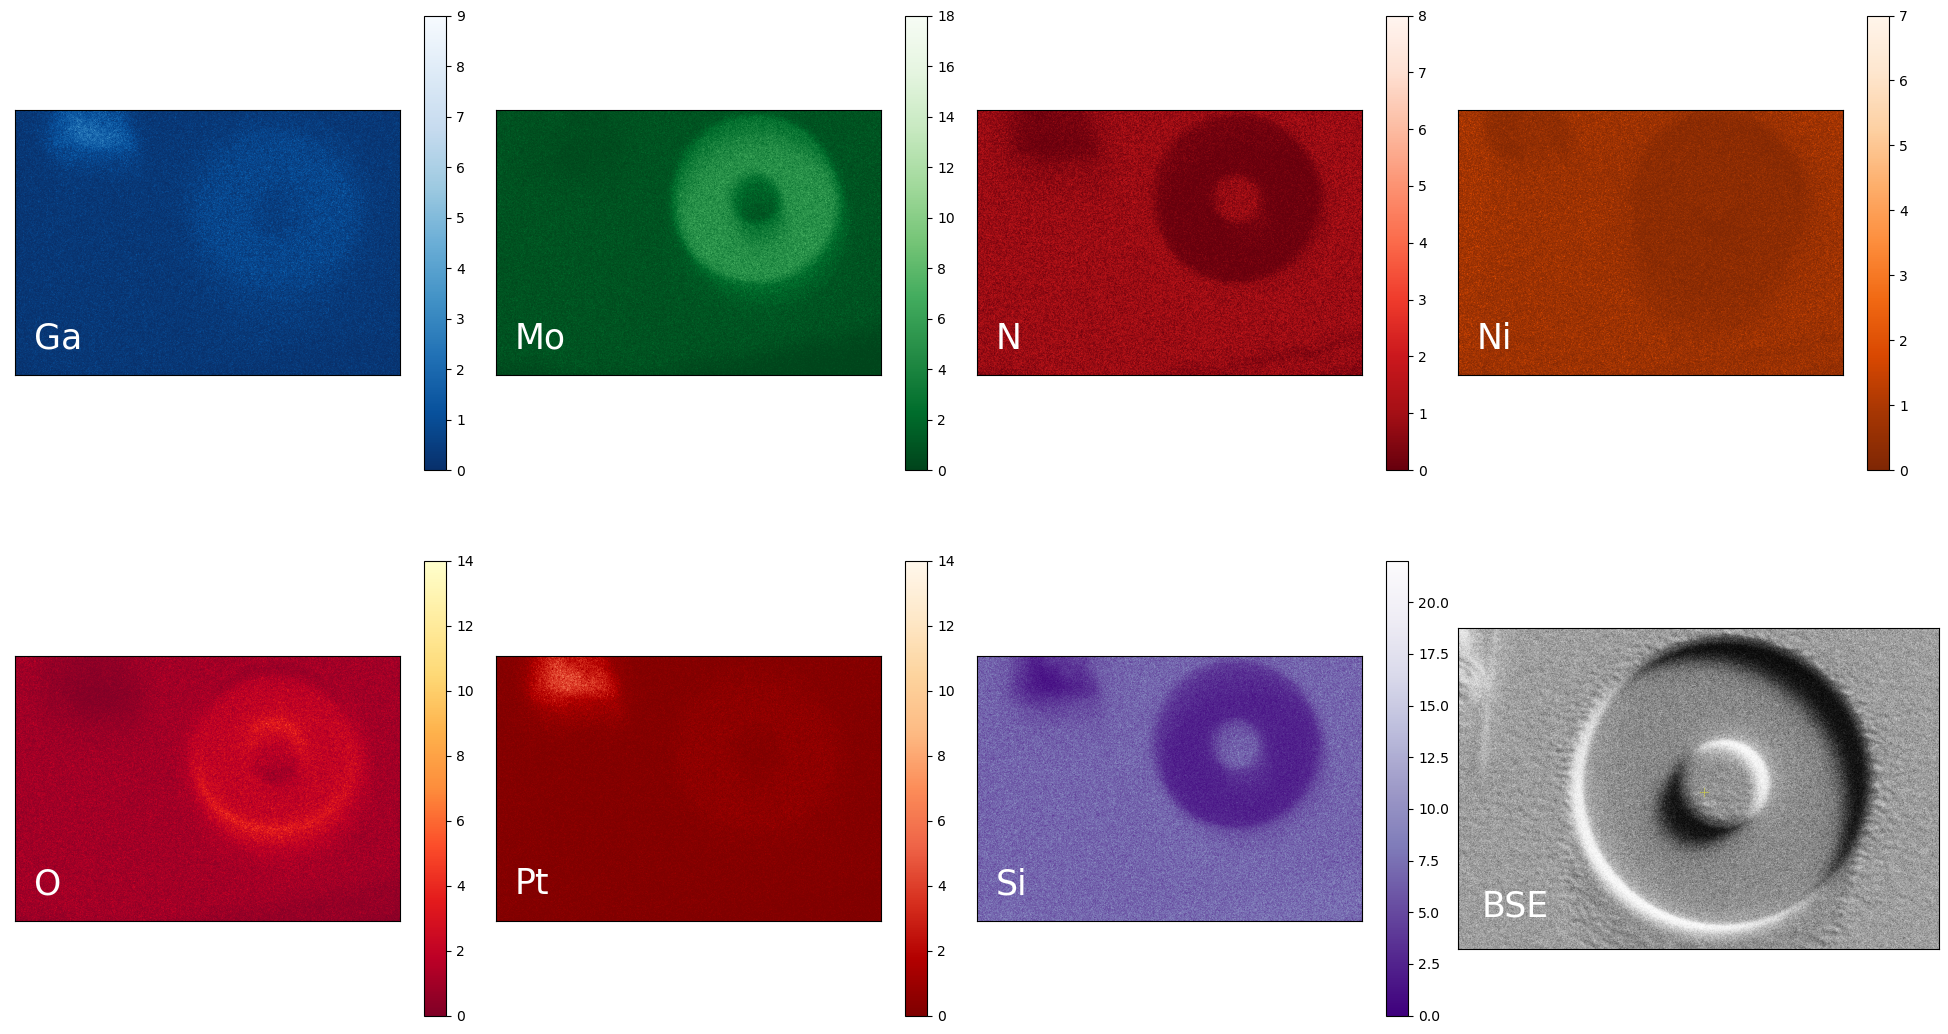

In [38]:
fig

In [39]:
fig.savefig('EDS.png', dpi=300)

In [11]:
heksagon_data = tif.imread('BSE heksagon 4kv 02A.tif')
tif0 = tif.TiffFile('BSE heksagon 4kv 02A.tif')

In [12]:
tif0.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:17:13 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 4000,
  'Spot': 9,
  'StigmatorX': 0.000553363,
  'StigmatorY': 0.000844406,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 4000,
  'HFW': 1.72667e

In [15]:
heksagon_data = tif.imread('BSE donut.tif')
tif0 = tif.TiffFile('BSE donut.tif')
tif0.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:13:41 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 4000,
  'Spot': 9,
  'StigmatorX': 0.000553363,
  'StigmatorY': 0.000844406,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 4000,
  'HFW': 1.036e-0

In [3]:
tif1 = tif.TiffFile('BSE_T1_smultring+ptdep.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:24:46 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 4000,
  'Spot': 9,
  'StigmatorX': 0.00101215,
  'StigmatorY': 0.000712184,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 4000,
  'HFW': 2.072e-05

In [4]:
tif1 = tif.TiffFile('BSE_T1_sirkler_10kV.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:34:01 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 10000,
  'Spot': 9,
  'StigmatorX': -0.00117953,
  'StigmatorY': 0.000158168,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 10000,
  'HFW': 2.1702

In [6]:
tif1 = tif.TiffFile('SE_T2_sirkler_10kV.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:33:22 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 10000,
  'Spot': 9,
  'StigmatorX': -0.00117953,
  'StigmatorY': 0.000158168,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 10000,
  'HFW': 2.1702

In [7]:
tif1 = tif.TiffFile('SE polygon 4kv 02a.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:20:29 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 4000,
  'Spot': 9,
  'StigmatorX': 0.000553363,
  'StigmatorY': 0.000844406,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 4000,
  'HFW': 1.72667e

In [8]:
tif1 = tif.TiffFile('SE_T2_poly_10kV_serikke.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:41:27 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 10000,
  'Spot': 9,
  'StigmatorX': -0.00117953,
  'StigmatorY': 0.000165246,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 10000,
  'HFW': 1.7266

In [9]:
tif1 = tif.TiffFile('BSE_T1_poly_10kV.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:40:05 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 10000,
  'Spot': 9,
  'StigmatorX': -0.00117953,
  'StigmatorY': 0.000165246,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 10000,
  'HFW': 1.7266

In [10]:
tif1 = tif.TiffFile('BSE heksagon 4kv 02A.tif')
tif1.fei_metadata

{'User': {'Date': '10/06/2021',
  'Time': '06:17:13 PM',
  'User': 'Supervisor',
  'UserText': 'NTNU Nano',
  'UserTextUnicode': '4E0054004E00550020004E0061006E006F00'},
 'System': {'Type': 'SEM',
  'Dnumber': 9925407,
  'Software': '13.9.0.6258',
  'BuildNr': 6258,
  'Source': 'FEG',
  'Column': 'Nicole',
  'FinalLens': 'Nicole',
  'Chamber': 'xT-SSB',
  'Stage': '110 x 110',
  'Pump': 'TMP',
  'ESEM': 'no',
  'Aperture': 'AVA',
  'Scan': 'PIA 3.0',
  'Acq': 'PIA 3.0',
  'EucWD': 0.01,
  'SystemType': 'Apreo',
  'DisplayWidth': 0.518,
  'DisplayHeight': 0.324},
 'Beam': {'HV': 4000,
  'Spot': 9,
  'StigmatorX': 0.000553363,
  'StigmatorY': 0.000844406,
  'BeamShiftX': 0,
  'BeamShiftY': 0,
  'ScanRotation': -2.77556e-17,
  'ImageMode': 'Normal',
  'FineStageBias': 0,
  'Beam': 'EBeam',
  'Scan': 'EScan'},
 'EBeam': {'Source': 'FEG',
  'ColumnType': 'Nicole',
  'FinalLens': 'Nicole',
  'Acq': 'PIA 3.0',
  'Aperture': 'AVA',
  'ApertureDiameter': 3.2e-05,
  'HV': 4000,
  'HFW': 1.72667e